# Big Data Analytics – Tweets zur Präsidentschaftswahl der USA
Dieses Notebook zeigt das Vorgehen sowie das Ergebnis der Analyse von gesammelten Tweets, welche im Zeitraum der US-Präsidentschaftswahl geteilt wurden. Die folgende Tabelle zeigt die verschiedenen Komponenten der Analyse und deren Nutzen. Alle Dateien finden sich unter https://github.com/felixwortmann/tweeKaLytics sowie im Ordner neben diesem Notebook.

| Komponente | Aufgabe | Datei |
| --- | --- | --- |
| api_request > request.py | Anfrage an Twitter-API schicken, um Tweets* zu erhalten | [request.py](https://github.com/felixwortmann/tweeKaLytics/blob/main/api_request/request.py) |
| api_request > kafka_publish.py | Erhaltene Tweets an Kafka Queue schicken | [kafka_publish.py](https://github.com/felixwortmann/tweeKaLytics/blob/main/api_request/kafka_publish.py) |
| kafka_consumer > consumer.py | Tweets aus Kafka Queue laden und in MongoDB importieren | [consumer.py](https://github.com/felixwortmann/tweeKaLytics/blob/main/kafka_consumer/consumer.py) |

*Die Tweets werden nach den Schlagworten "Trump", "Biden" und "Election" gefiltert.

### Starten und Ausführen der Docker-Container
Die verschiedenen Komponenten sind mit Docker-Containern umgesetzt. Um diese zu starten und auszuführen, muss der Befehl `docker-compose up` ausgeführt werden.

## Komponente: [request.py](https://github.com/felixwortmann/tweeKaLytics/blob/main/api_request/request.py)
Zunächst wird die erste Komponente betrachtet, welche die Daten von der Twitter-API beschafft. Es musste zu diesem Zweck ein Twitter Developer Account erstellt werden, um den Zugriff auf die Schnittstelle mittels API-Keys zu gewährleisten. Das Python-Skript stellt eine Verbindung mit der API her, nachdem es die API-Keys aus einer (nicht im GitHub befindlichen) Text-Datei geladen hat. Schließlich wird ein `StreamListener` (aus der Bibliothek `tweepy`) erzeugt, welcher auf die API zugreift und den Stream startet. Nun werden alle Tweets mit den Schlagwörtern "Trump", "Biden" und "Election" von der API aus gesendet. In dieser Komponente wird außerdem die Methode `send_json` aus der, im Folgenden beschriebenen, Komponente `kafka_publish.py` aufgerufen.

## Komponente: [kafka_publish.py](https://github.com/felixwortmann/tweeKaLytics/blob/main/api_request/kafka_publish.py)
Diese Komponente beziehungsweise die einzige Methode in dieser Komponenten wird dann aufgerufen, wenn im Skript für die API-Anfrage Daten empfangen werden. Von der API wird eine JSON-Datei gesendet, welche nun von der Methode an den `KafkaProducer` (aus der Bibliothek `kafka`) gesendet werden. Hierfür werden die Daten an das topic "tweets" geschickt.

## Komponente: [consumer.py](https://github.com/felixwortmann/tweeKaLytics/blob/main/kafka_consumer/consumer.py)
Die dritte und letzte, für die Datenverarbeitung notwendige, Komponente ist für den Datenimport in die Datenbank. Die Entscheidung fiel für eine MongoDB, da der Umgang mit dieser aufgrund von Erfahrung keine große Schwierigkeit darstellte. Außerdem ist eine MongoDB eine adäquate Wahl für große Datenmengen (hu**mongo**us). Für diese Komponente wurden die Bibliotheken `pymongo` sowie erneut `kafka` verwendet. In dem Datenbanksystem wurde die Datenbank "twitter" und dort die Collection "tweets" erstellt. Der erste Schritt in diesem Skript ist die Beschaffung der Daten aus der Kafka Queue; hierfür wird mit einem `KafkaConsumer` auf das Topic "tweets" zugegriffen. Eine for-Schleife iteriert dann über die im Consumer befindlichen Messages und fügt diese in die Collection ein.

## Containerisierung
Um die verschiedenen Komponenten laufen zu lassen, wurden Docker Container angelegt. Die [docker-compose.yml](https://github.com/felixwortmann/tweeKaLytics/blob/main/docker-compose.yml) zeigt die Erstellung der einzelnen Container.

+ `kafka-service-tweekalytics`: Kafka Container
+ `zookeeper`: Zookeeper, nötig für Kafka
+ `python-api-request`: Skript für die API-Anfrage & Importierung nach Kafka
+ `python-kafka-consumer`: Skript für Datenbeschaffung aus Kafka & Importierung nach MongoDB
+ `database`: MongoDB Container

<div style="page-break-after: always;"></div>

### Imports

`pip3 install -r requirements.txt`

In [1]:
from pymongo import MongoClient
from bson.json_util import loads, dumps
import json
import nltk
from nltk.corpus import stopwords
import collections
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Math, Latex

### Füllwörter
Dieses Paket liefert englische Füllwörter, welche später bei der Analyse ignoriert werden sollen. Außerdem werden eigene Wörter, welche bei der Analyse auffielen und als unnötig betrachtet wurden, hinzugefügt.

In [2]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
ignore_words = stop_words | {'rt', '', '-', '&amp;', 'like', 'get', 'one', 'via', 'new', 'i\'m'}

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/felixwortmann/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Datenbankverbindung herstellen
Es wurde ein Docker-Container für die MongoDB gestartet mit Port 27017. Hier wird nun die Verbindung auf die Collection "tweets" der Datenbank "twitter" hergestellt.

In [3]:
client = MongoClient('mongodb://localhost:27017')
db = client['twitter']
collection = db['tweets']

### Daten laden
Nun werden die Daten in Form von JSON-Dateien aus der Datenbank geladen und in der Variable `data` gespeichert.

In [4]:
data = json.loads(dumps(collection.find()))
len(data)

437512

<div style="page-break-after: always;"></div>

### Rausfiltern der Tweet-Inhalte
Nun werden alle Tweets verarbeitet, indem die Tweet-Inhalte als Liste `text_strings` gespeichert werden.

In [5]:
text_strings = []
for d in data:
    if "text" in d.keys():
        text_strings += [d["text"]]

Anschließend wird das Dictionary `words_dict` erzeugt, welche die verwendeten Wörter in Verbindung mit dem Jahr der Erstellung des zugehörigen Twitter-Accounts (im Folgenden aus Gründen der besseren Lesbarkeit einfach als "Jahr" bezeichnet) auf deren Häufigkeit zuweist. Es wird also gespeichert, wie oft jegliche Kombination aus Wort und Jahr auftritt.

In [6]:
words_dict = {}
for d in data:
    if not "text" in d.keys() or not "user" in d.keys() or not "created_at" in d["user"].keys() or d["user"]["created_at"] == None:
        continue
    text = d["text"].lower()
    created = d["user"]["created_at"][-4:]
    
    for word in text.split(' '):
        pair = (word, created)
        if pair in words_dict.keys():
            words_dict[pair] += 1
        else:
            words_dict[pair] = 1

<div style="page-break-after: always;"></div>

### Top-3 Wörter pro Jahr der Account-Erstellung
Im Folgenden findet die erste Analyse durchgeführt. Dazu wird das zuvor erstellte Dictionary bezüglich der Häufigkeiten von Wort/Jahr Kombinationen verwendet. Es wird nun betrachtet, welches die drei am häufigsten verwendeten Wörter pro Jahr der Account-Erstellung sind.

In [7]:
result = {}

for pair in words_dict.keys():
    word, year = pair
    amount = (word, words_dict[pair])
    
    if year in result.keys():              
        result[year] = result[year] + [(word, words_dict[pair])]
            
    else:
        result[year] = [(word, words_dict[pair])]

for year in sorted(result.keys()):
    print(year, end="")
    value = result[year]
    r = [(k,v) for k, v in sorted(value, key=lambda item: -item[1]) if k not in ignore_words]
    for x in r[:3]:
        print("    ", x[0],":", x[1], end="")
    print("")

2006     trump : 24     donald : 15     biden : 12
2007     trump : 513     biden : 364     joe : 163
2008     trump : 2354     biden : 1787     election : 1078
2009     trump : 11680     biden : 8994     election : 5616
2010     trump : 6571     biden : 4845     de : 2949
2011     trump : 8837     biden : 6020     election : 4127
2012     trump : 9107     biden : 6554     election : 4301
2013     trump : 7086     biden : 5225     election : 3178
2014     trump : 5873     biden : 4272     election : 2914
2015     trump : 5879     biden : 4502     election : 3172
2016     trump : 8186     biden : 5769     election : 4406
2017     trump : 8648     biden : 6083     election : 4478
2018     trump : 7291     biden : 4973     election : 3733
2019     trump : 8761     biden : 6328     election : 3979
2020     trump : 17613     biden : 12741     election : 9049


### Durchschnittliches Alter der Accounts
Für spätere Vergleiche wird an dieser Stelle das durchschnittliche Alter der Twitter-Accounts (von den hier analysierten Tweets) berechnet.

In [8]:
years = [int(year) for d in data if "user" in d.keys() for year in [d["user"]["created_at"][-4:]]]
sum(years) / len(years)

2014.6281741628043

Somit liegt das durchschnittliche Alter der hier betrachteten Accounts bei ~5,5 Jahren.

### Tiefere Analyse der Tweets

Die folgenden zwei Methoden sind Hilfsmethoden zur im Folgenden erklärten Analyse der Tweets.

In [9]:
def words_by_account_year(word_set):
    word_result = {}
    for y in result.keys():
        for w,c in result[y]:
            if w in word_set:
                if y in word_result.keys():
                    word_result[y] += c
                else:
                    word_result[y] = c
    return [(y, word_result[y]) for y in sorted(word_result)]

def plot_by_account_year(word_set):
    wl = words_by_account_year(word_set)
    group_names = list([k for k,v in wl])
    group_data = list([v for k,v in wl])
    return group_names,group_data

<div style="page-break-after: always;"></div>

### Untersuchung von Wörtern: 
Die hier definierten Wörter stehen primär in Verbindung mit dem Vorwurf eines Wahlbetrugs.

+ fraud
+ lie
+ steal
+ cheating
+ swindling
+ desception
+ trickery
+ illegal
+ voterfraud

Im Folgenden wird die Verteilung zwischen Anzahl der Tweets, welche eines der definierten Wörter verwenden und dem Jahr der Account-Erstellung des zugehörigen Tweets untersucht.

<BarContainer object of 15 artists>

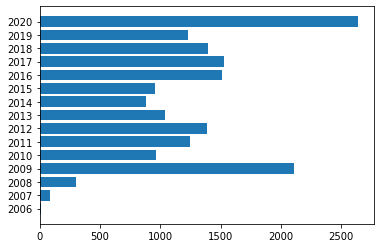

In [10]:
fraud_word_set = {"fraud","lie","steal","cheating","swindling","desception","trickery","illegal",
                  "voterfraud"}
fig, ax = plt.subplots()
key_data, value_data = plot_by_account_year(fraud_word_set)
ax.barh(key_data,value_data)

### Folgerung

Die Daten lassen vermuten, dass viele Accounts zur Zeit der Wahl erstellt wurden, um sich eben dazu zu äußern.
<br><br>
Im Jahr 2008 hat Barack Obama als Demokrat die Wahl gewonnen, woraufhin er 2009 Präsident wurde. Joe Biden war hier Vizepräsident<br> 
2020 hat Donald Trump die Wahl als Republikaner verloren. <br><br>

Es ist zu vermuten, dass die Accounts, die damals erstellt wurden, einen ähnlichen Standpunkt vertreten, wie die Accounts von 2020. Die Wörter, nach denen wir gesucht haben, lassen auch vermuten, dass die Accountinhaber die Wahlergebnisse nicht akzeptieren.
<br><br>
Aufgrund der verhältnismäßig kleinen Datenmenge, sind dies allerdings nur Vermutungen.

<div style="page-break-after: always;"></div>

### Untersuchung von Wörtern: 

Folgende Wörter werden als solche definiert, welche in Verbindung mit Glückwünschen an den neugewählten Präsidenten sowie generell positiven Aussagen stehen.


+ congratulations  
+ united  
+ party  
+ win  
+ president-elect
+ elect
+ presidentelect
- congrats

Es folgt eine Analyse analog zu der Obigen, diesmal jedoch basierend auf den neu definierten Wörtern.

<BarContainer object of 14 artists>

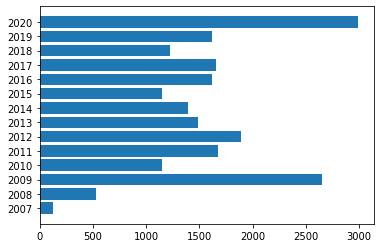

In [11]:
congratulations_word_set = {
    "congratulations",
    "united",
    "party",
    "win",
    "president-elect",
    "elect",
    "presidentelect",
    "congrats"
}
fig, ax = plt.subplots()
key_data, value_data = plot_by_account_year(congratulations_word_set)
ax.barh(key_data,value_data)

### Folgerung

Diese Ergebnisse untermauern die obige Vermutung, weil zwar die Suche bei allen Tweets nach "Trump","Biden" und "Election" war, die Erstellungsdaten der Accounts jedoch relativ verteilt sind. Während die "Spikes" zwar immer noch zu erkennen sind, ist der Abstand geringer und liegt daher nahe, dass viele der Accounts, die hier postivie Tweets verfassen, nicht extra für die Wahl erstellt wurden.

<div style="page-break-after: always;"></div>

### Analyse von Hashtags
Im Folgenden werden die Hashtags und die jeweilige Häufigkeit des Auftretens dieser berechnet.

In [12]:
hashtag_dir = {}
for tweet in data:
    if "entities" in tweet.keys():
        hashtags = tweet["entities"]["hashtags"]
        for hashtag in hashtags:
            hashtag_text = hashtag["text"].lower()
            if hashtag_text not in hashtag_dir.keys():
                hashtag_dir[hashtag_text] = 0
            hashtag_dir[hashtag_text] += 1
hashtag_dir = [(k,v) for k, v in sorted(hashtag_dir.items(), key=lambda item: -item[1]) if k not in ignore_words]

### Herausfinden von Trump-freundlichen und Biden-Freundlichen Tweets
Es ist per se schwierig herauszufinden, ob ein Tweet von einem Trump- oder einem Biden-Anhänger erstellt wurde. Als Richtwert dafür werden zwei Mengen von Hashtags definiert, welche einer der beiden Seiten leicht zugeordnet werden können.

In [13]:
trump_friendly_hashtags = {
    "trump2020",
    "trumppence2020",
    "obamagate",
    "maga",
    "maga2020",
    "trump",
    "donaldtrump",
    "mikepence"
}
biden_friendly_hashtags = {
    "biden2020",
    "bidenharris2020",
    "presidentelectbiden",
    "bidenwin",
    "biden",
    "joebiden",
    "kamalaharris"
}

In [14]:
biden_tweets = []
trump_tweets = []
for tweet in data:
    if "entities" in tweet.keys():
        hashtags = tweet["entities"]["hashtags"]
        for hashtag in hashtags:
            hashtag_text = hashtag["text"].lower()
            if hashtag_text  in biden_friendly_hashtags:
                biden_tweets += [tweet["text"]]
            if hashtag_text in trump_friendly_hashtags:
                trump_tweets += [tweet["text"]]
biden_words = [word for tweet in biden_tweets for word in tweet.split(' ')]
trump_words = [word for tweet in trump_tweets for word in tweet.split(' ')]

Die folgende Methode dient zur Berechnung der Häufigkeit von bestimmten Wörtern, einmal für Biden-freundliche und einmal für Trump-freundliche Tweets.

In [15]:
def occurrences(word_set):
    return (len([word for word in biden_words if word in word_set]), len([word for word in trump_words if word in word_set]))

Nun wird untersucht, wie die Verteilung bei der Verwendung von den oben definierten Wörtern, welche in Verbindung mit dem Vorwurf eines Wahlbetrugs stehen, lautet.

<BarContainer object of 2 artists>

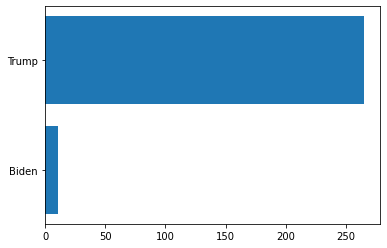

In [16]:
fig, ax = plt.subplots()
value_data = occurrences(fraud_word_set)
ax.barh(["Biden", "Trump"], value_data)

Es ist zu sehen, dass eine klare Mehrheit der Tweets, welche die negativ konnotierten Wörter in Verbindung mit einem Wahlbetrug, Hashtags enthalten, die darauf schließen lassen, dass es sich bei dem Ersteller um einen Trump-Anhänger handelt.

<BarContainer object of 2 artists>

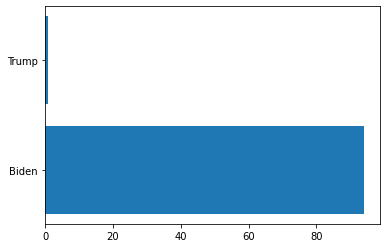

In [17]:
fig, ax = plt.subplots()
value_data = occurrences(congratulations_word_set)
ax.barh(["Biden", "Trump"], value_data)

Bei den Wörtern, welche positiv konnotiert und in Verbindung mit Glückwünschen stehen, zeichnet sich erneut eine klare Mehrheit ab. Dieses mal jedoch handelt es sich bei den Tweet-Verfassern vermutlicherweise vorrangig um Biden-Unterstützer, was die verwendeten Hashtags naheliegen.

Erneut ist zu erwähnen, dass die Analyse keineswegs tief genug respektive mit genügend Daten durchgeführt wird, um ein klares Fazit ziehen zu können. Es handelt sich lediglich um Vermutungen aufgrund der vorliegenden Daten.

<div style="page-break-after: always;"></div>

### Account-Alter von Trump- und Biden-Anhängern
Schließlich wird untersucht, wann die Accounts von geteilten Tweets, welche entweder auf eine\*n Biden-Unterstützer\*in oder auf eine\*n Trump-Unterstützer\*in vermuten lassen, erstellt wurden.

In [18]:
trump_years = {}
biden_years = {}
for tweet in data:
    if "user" in tweet.keys():
        year = tweet["user"]["created_at"][-4:]
        if "entities" in tweet.keys():
            hashtags = tweet["entities"]["hashtags"]
            for hashtag in hashtags:
                hashtag_text = hashtag["text"].lower()
                if hashtag_text in biden_friendly_hashtags:
                    if year in biden_years.keys():
                        biden_years[year] += 1
                    else:
                        biden_years[year] = 1
                if hashtag_text in trump_friendly_hashtags:
                    if year in trump_years.keys():
                        trump_years[year] += 1
                    else:
                        trump_years[year] = 1
trump_years = [(y, trump_years[y]) for y in sorted(trump_years)]
biden_years = [(y, biden_years[y]) for y in sorted(biden_years)]

In [19]:
def created(trump):
    if trump:
        return (list([k for k, v in trump_years]), list([v for k, v in trump_years]))
    return (list([k for k, v in biden_years]), list([v for k, v in biden_years]))

Folgende Grafik zeigt die Verteilung der Account-Erstellungsjahre von Tweets mit Trump-freundlichen Hashtags.

<BarContainer object of 14 artists>

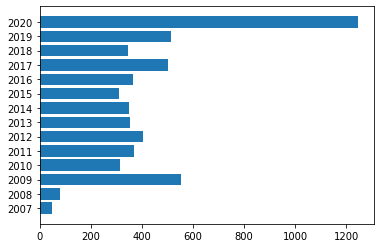

In [20]:
fig, ax = plt.subplots()
key_data, value_data = created(True)
ax.barh(key_data, value_data)

Folgende Grafik zeigt die Verteilung der Account-Erstellungsjahre von Tweets mit Biden-freundlichen Hashtags.

<BarContainer object of 14 artists>

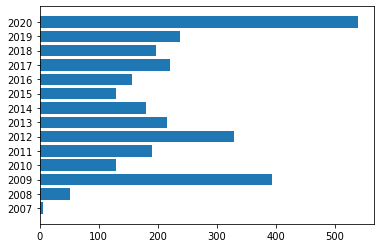

In [21]:
fig, ax = plt.subplots()
key_data, value_data = created(False)
ax.barh(key_data, value_data)

Es ist zu sehen, dass bei den Accounts mit Trump-freundlichen Tweets das Erstellungsjahr zu einem Großteil 2020 ist. Während 1.200 der Accounts 2020 erstellt wurden, ist das nächste Jahr (2009) nur mit knapp 600 Accounts vertreten. Die Vermutung, warum viele Accounts auch 2009 erstellt wurden, deckt sich mit der oben bereits getätigten Aussage, dass in diesem Jahr ein Republikaner die Präsidentschaftswahl verloren hat und diejenigen, die damals einen Account erstellten, eine ähnliche Meinung in 2020 vertreten.

Vergleicht man die Ergebnisse mit denen der Biden-freundlichen Hashtags, sieht man, dass der Unterschied nicht so stark ist. So wurden zwar hier auch die meisten Accounts in 2020 erstellt, jedoch ist der Abstand – wohlgemerkt bei einer geringeren Ausgangsmenge – kleiner.

Es ist wichtig zu betrachten, dass sich die Skalen auf der x-Achse unterscheiden.

<div style="page-break-after: always;"></div>

## Fazit
Insgesamt lassen sich die Ergebnisse erneut lediglich als Vermutungen beschreiben, da die Ausgangsmenge an Daten nicht groß genug für eine fundamentierte Schlussfolgerung ist. Nichtsdestotrotz bieten die Analysen interessante Einblicke in das Tweet-Verhalten der Nutzer und erlaubt es, Vermutungen herzuleiten und Tendenzen zu erkennen.

<div style="page-break-after: always;"></div>

# Anhang
Die Bearbeitung der einzelnen Abschnitte fand folgendermaßen statt:

+ Einleitung: Redmann
+ Komponente `request.py` und `kafka_publish.py`: Wortmann
+ Komponente `consumer.py`: Redmann
+ Containerisierung: Wortmann
+ Abschnitt "Füllwörter, Datenbankverbindung, Daten laden": Redmann
+ Abschnitt "Rausfiltern der Tweet-Inhalte": Wortmann
+ Abschnitt "Top-3 Wörter & Durchschnittliches Alter": Redmann
+ Abschnitt "Tiefere Analyse": Wortmann
+ Abschnitt "Untersuchung von negativen Wörtern": Redmann
+ Abschnitt "Untersuchung von positiven Wörtern": Wortmann
+ Abschnitt "Analyse von Hashtags und Verwendung von negativen/positiven Wörtern": Redmann
+ Abschnitt "Account-Alter & Fazit": Wortmann